In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
import datetime as dt
import seaborn as sb
sb.set()

from math import sqrt
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error
from pandas. plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.filterwarnings("ignore")

In [2]:
#importing data

apple_data = pd.read_csv("AAPL.csv",index_col=0,parse_dates=True)
apple_test = pd.read_csv("AAPL_test.csv",index_col=0,parse_dates=True)
print('Shape Of Data for Orignal data',apple_data.shape)
print('Shape Of Data for Test data',apple_test.shape)

Shape Of Data for Orignal data (10272, 6)
Shape Of Data for Test data (22, 6)


In [3]:
#checking for NULL values

apple_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
apple_test.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
#extracting 10 years worth of data

apple_2013_to_2021 = apple_data['2013-01-01':'2021-09-08']
print('Shape of Data',apple_2013_to_2021.shape)
apple_2013_to_2021

Shape of Data (2187, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.985447,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.771053,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.303900,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.207998,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.251616,458707200
...,...,...,...,...,...,...
2021-09-01,152.830002,154.979996,152.339996,152.509995,152.509995,80313700
2021-09-02,153.869995,154.720001,152.399994,153.649994,153.649994,71115500
2021-09-03,153.759995,154.630005,153.089996,154.300003,154.300003,57808700


In [6]:
#Filtering unwanted values in the dataset

apple = apple_2013_to_2021[["Adj Close"]]
apple.describe()

,Adj Close
count,2187.000000
mean,46.774904
std,35.377808
min,12.152316
25%,23.241143
50%,34.228165
75%,52.552049
max,156.690002


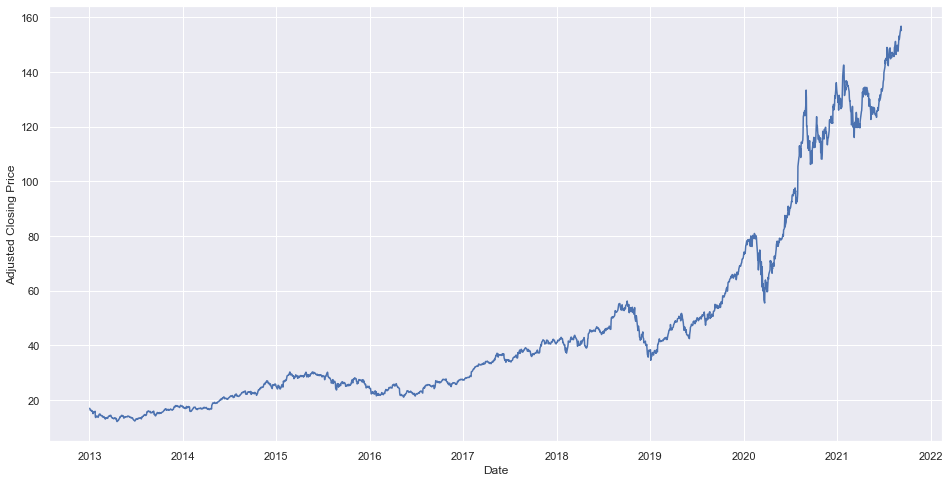

In [7]:
#plotting the graph

plt.figure(figsize=(16,8))
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Closing Price')
ax1.plot(apple)

## Checking for stationary - Needs Constanst Mean and Variance

### Method 1 - Rolling statistics
### Method 2 - Duckey fuller

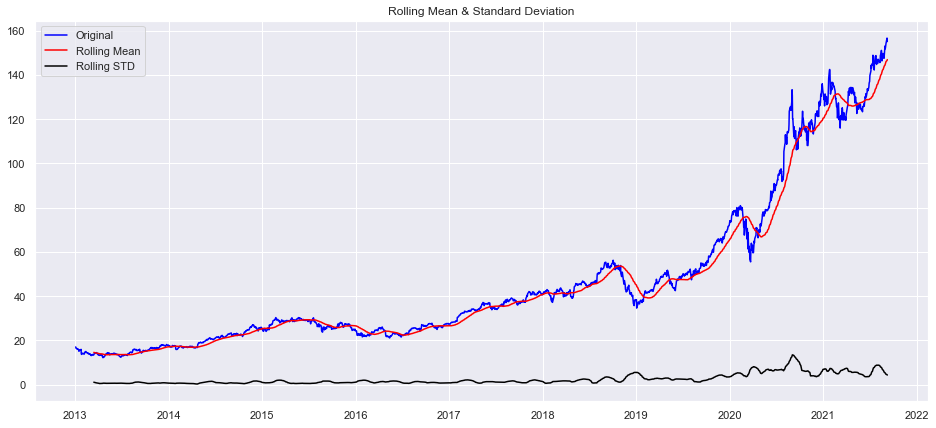

In [8]:
#Method 1 - Rolling statistics

rolling_mean = apple.rolling(50).mean()
rolling_std = apple.rolling(50).std()

plt.figure(figsize=(16,7))
fig = plt.figure(1)

#plotting rolling stats
orig = plt.plot(apple, color='blue', label='Original')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_std, color='black', label='Rolling STD')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [9]:
#Method 2 - Duckey fuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ",dftest[1])
    print("3. Num of Lags : ",dftest[2])
    print("4. Num of Observations Used for ADF Regression and Critical Values Calculation : ",dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t",key,": ",val)

In [10]:
ad_test(apple)

1. ADF :  2.7297153327290977
2. P-Value :  0.9990880080721897
3. Num of Lags :  26
4. Num of Observations Used for ADF Regression and Critical Values Calculation :  2160
5. Critical Values : 
	 1% :  -3.4333810594081227
	 5% :  -2.862879013318124
	 10% :  -2.5674828242884087


### Since the P-Value is more than 0.05, the graph is not stationary. Therefore, we will be using differencing to make the graph stationary.

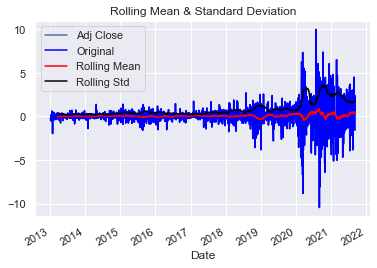

In [11]:
#Differencing
apple_diff = apple - apple.shift(1)
apple_diff.dropna().plot()

# Rolling statistics
rollmean = apple_diff.rolling(50).mean()
rollstd = apple_diff.rolling(50).std()

orig = plt.plot(apple_diff, color='blue', label='Original')
mean = plt.plot(rollmean, color='red', label='Rolling Mean')
std = plt.plot(rollstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [12]:
ad_test(apple_diff.dropna())

1. ADF :  -9.359847067137858
2. P-Value :  7.876824469634825e-16
3. Num of Lags :  26
4. Num of Observations Used for ADF Regression and Critical Values Calculation :  2159
5. Critical Values : 
	 1% :  -3.4333824650008378
	 5% :  -2.862879633943035
	 10% :  -2.5674831547315


### P-Value is less than 0.05 which means graph is stationary.

In [13]:
#Plotting Autocorrelation and Partial Autocorrelation

lag_acf = acf(apple_diff.dropna(),nlags=20)
lag_pacf = pacf(apple_diff.dropna(),nlags=20)

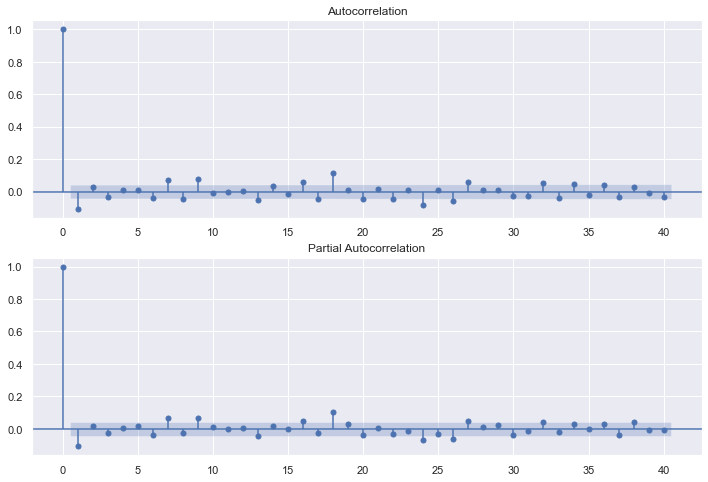

In [14]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(apple_diff.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(apple_diff.dropna(),lags=40,ax=ax2)

In [15]:
#Using Auto Arima to predict P,D,Q values

predictions = auto_arima(apple_diff.dropna(), trace=True, suppress_warnings=True)
predictions.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8588.994, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7762.025, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8586.994, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7509.805, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7346.257, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=7237.777, Time=0.31 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=7198.592, Time=0.43 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=7196.594, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=7235.779, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.91 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.74 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2186
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -3592.297
Date:                Fri, 25 Mar 2022   AIC                           7196.594
Time:                        00:08:53   BIC                           7230.730
Sample:                             0   HQIC                          7209.072
                               - 2186                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9287      0.010    -95.498      0.000      -0.948      -0.910
ar.L2         -0.7150      0.013    -56.406      0.000      -0.740      -0.690
ar.L3         -0.5457      0.012    -45.390      0.000      -0.569      -0.522
ar.L4         -0.3449      0.012    -27.836      0.000      -0.369      -0.321
ar.L5         -0.1368      0.010    -13.988      0.000      -0.156      -0.118
sigma2         1.5679      0.016     95.675      0.000       1.536       1.600
===================================================================================
Ljung-Box (L1) (Q):                   1.86   Jarque-Bera (JB):             22700.13
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):              30.35   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
model = ARIMA(apple, order=(5,1,0))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                 2186
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3410.083
Method:                       css-mle   S.D. of innovations              1.151
Date:                Fri, 25 Mar 2022   AIC                           6834.165
Time:                        00:08:53   BIC                           6873.994
Sample:                             1   HQIC                          6848.724
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0633      0.022      2.823      0.005       0.019       0.107
ar.L1.D.Adj Close    -0.1061      0.021     -4.959      0.000      -0.148      -0.064
ar.L2.D.Adj Close     0.0154      0.022      0.714      0.475      -0.027       0.058
ar.L3.D.Adj Close    -0.0259      0.022     -1.205      0.228      -0.068       0.016
ar.L4.D.Adj Close     0.0038      0.022      0.177      0.859      -0.038       0.046
ar.L5.D.Adj Close     0.0142      0.021      0.662      0.508      -0.028       0.056
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0525           -1.0965j            2.3270           -0.4219
AR.2           -2.0525           +1.0965j            2.3270            0.4219
AR.3            0.6596           -2.1784j            2.2761           -0.2032
AR.4            0.6596           +2.1784j            2.2761            0.2032
AR.5            2.5167           -0.0000j            2.5167           -0.0000
-----------------------------------------------------------------------------
"""

In [17]:
apple

,Adj Close
Date,
2013-01-02,16.985447
2013-01-03,16.771053
2013-01-04,16.303900
2013-01-07,16.207998
2013-01-08,16.251616
...,...
2021-09-01,152.509995
2021-09-02,153.649994
2021-09-03,154.300003


In [18]:
apple_test

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-09,155.490005,156.110001,153.949997,154.070007,153.649719,57305700
2021-09-10,155.000000,155.479996,148.699997,148.970001,148.563614,140646400
2021-09-13,150.630005,151.419998,148.750000,149.550003,149.142044,102404300
2021-09-14,150.350006,151.070007,146.910004,148.119995,147.715927,109296300
2021-09-15,148.559998,149.440002,146.369995,149.029999,148.623444,83281300
2021-09-16,148.440002,148.970001,147.220001,148.789993,148.384094,68034100
2021-09-17,148.820007,148.820007,145.759995,146.059998,145.661560,129868800
2021-09-20,143.800003,144.839996,141.270004,142.940002,142.550079,123478900
2021-09-21,143.929993,144.600006,142.779999,143.429993,143.038727,75834000


In [19]:
#Predicting the future values

start = len(apple)
end = len(apple)+len(apple_test)-1
prediction = model.predict(start=start, end=end, typ='levels')
prediction.index = apple_test.index
print(prediction)

Date
2021-09-09    155.380946
2021-09-10    155.354099
2021-09-13    155.489918
2021-09-14    155.565427
2021-09-15    155.608376
2021-09-16    155.674716
2021-09-17    155.736040
2021-09-20    155.801174
2021-09-21    155.864243
2021-09-22    155.927347
2021-09-23    155.990628
2021-09-24    156.053889
2021-09-27    156.117199
2021-09-28    156.180471
2021-09-29    156.243749
2021-09-30    156.307027
2021-10-01    156.370305
2021-10-04    156.433584
2021-10-05    156.496863
2021-10-06    156.560142
2021-10-07    156.623420
2021-10-08    156.686699
dtype: float64


<AxesSubplot:xlabel='Date'>

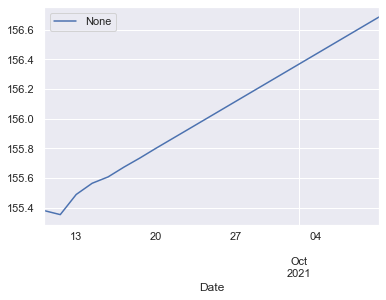

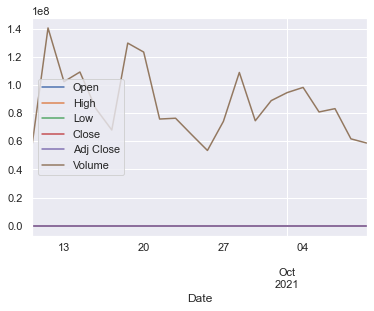

In [20]:
prediction.plot(legend=True)
apple_test.plot()